# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [1]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [2]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=80  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=256, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=256, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=16, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 3
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs,out_channel,in_Channel]
        w = self.conv1D(w)
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
        # -------------- softmax ---------------------------
        #print(w.shape)
        w = w.view(w.shape[0],w.shape[1],w.shape[2],1,1)
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
        out=out.view(out.shape[0],1,out.shape[1],out.shape[2],out.shape[3])
        #print("x size:",out.shape)
        
        out=out*w
        #print("after fusion x size:",out.shape)
        out=out.sum(dim=2)
        
        out = F.relu(self.bn2(out))
        
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [3]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block_Attention_HALF(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention_HALF, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        #------------------------ 一半 ------------------------------
        self.conv2 = nn.Conv2d(in_planes, int(out_planes*0.125), kernel_size=1, stride=1, padding=0, bias=True)
        
        #------------------------ 另一半 ----------------------------
        self.scaleLayer= nn.Conv1d(1, 1, 1, stride=1,padding=0,groups=1,dilation=1,bias=True)
        
        one_conv_kernel_size = 17 # [3,7,9]
        self.conv1D= nn.Conv1d(1, int(out_planes*0.875), one_conv_kernel_size, stride=1,padding=8,groups=1,dilation=1,bias=True) # 在__init__初始化        
        
        #------------------------------------------------------------
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu6(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        #w=w[0]-torch.mean(w[0])
        w=torch.randn(w[0].shape).cuda()*0.1
        
        a=torch.randn(1).cuda()*0.1
        if a>0.37:
            print(w.shape)
            print(w)
        
        w=w.view(1,1,in_channel)
        w=self.scaleLayer(w)
        if a>0.37:
            print(self.scaleLayer.weight)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        
        #-------------------------------------
        w = 0.1*F.tanh(w) # [-0.5,+0.5]
        
        if a>0.37:
            print(w.shape)
            print(w)
            
        # [bs=1,out_channel//2,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel//2,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out_1=self.conv2(out)
        out_2=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)
        out=torch.cat([out_1,out_2],1)
        
        # ----------------------- 试一试不要用relu -------------------------------
        out = F.relu6(self.bn2(out))
        
        return out

class Block_Attention(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 17 # [3,7,9]
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=8,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        
        w=w[0]
        
        w=w.view(1,1,in_channel)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
         # [bs=1,out_channel,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)

        out = F.relu(self.bn2(out))
        
        return out


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), [1024,1]]
    cfg = [64, (128,2), 128, 256, 256, (512,2), 512, [512,1], [512,1],[512,1], [512,1], [1024,1], [1024,1]]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention_HALF(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
#scheduler = StepLR(optimizer, step_size=70, gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,70,75,80], gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [5]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 5*show_step == 0:
#             if batch_idx % 2*show_step == 0:
#                 print(model.layers[1].conv1D.weight.shape)
#                 print(model.layers[1].conv1D.weight[0:2][0:2])
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1=open("Cifar10_INFO.txt","a+")
#             f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [6]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         valid_loss, correct, len(valid_idx),
#         100. * correct / len(valid_idx)))
#     f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [7]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct.cpu().numpy() / len(test_loader.dataset)))
#     f1.close()

In [8]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [9]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
    if epoch>=10 and (epoch-10)%2==0:
        test(epoch)
    
# writer = SummaryWriter() 
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.310075, Accuracy: 10.94
Train Epoch: 0 [1280/50000 (3%)]	Loss: 2.263136, Accuracy: 19.53
Train Epoch: 0 [2560/50000 (6%)]	Loss: 2.213202, Accuracy: 16.80
Train Epoch: 0 [3840/50000 (9%)]	Loss: 2.129346, Accuracy: 14.06
Train Epoch: 0 [5120/50000 (11%)]	Loss: 2.058116, Accuracy: 20.70
Train Epoch: 0 [6400/50000 (14%)]	Loss: 2.122582, Accuracy: 14.45
Train Epoch: 0 [7680/50000 (17%)]	Loss: 2.034724, Accuracy: 21.88
Train Epoch: 0 [8960/50000 (20%)]	Loss: 2.014674, Accuracy: 20.70
Train Epoch: 0 [10240/50000 (23%)]	Loss: 2.013421, Accuracy: 21.09
Train Epoch: 0 [11520/50000 (26%)]	Loss: 2.002305, Accuracy: 20.31
Train Epoch: 0 [12800/50000 (28%)]	Loss: 2.036500, Accuracy: 23.05
Train Epoch: 0 [14080/50000 (31%)]	Loss: 1.956254, Accuracy: 23.05
Train Epoch: 0 [15360/50000 (34%)]	Loss: 1.979172, Accuracy: 21.09
Train Epoch: 0 [16640/50000 (37%)]	Loss: 1.948001, Accuracy: 21.09
Train Epoch: 0 [17920/50000 (40%)]	Loss: 1.953425, Accuracy: 26.95
Train Epoc

Train Epoch: 3 [14080/50000 (31%)]	Loss: 1.109918, Accuracy: 58.20
Train Epoch: 3 [15360/50000 (34%)]	Loss: 1.063343, Accuracy: 63.67
Train Epoch: 3 [16640/50000 (37%)]	Loss: 1.041346, Accuracy: 62.11
Train Epoch: 3 [17920/50000 (40%)]	Loss: 1.040913, Accuracy: 60.16
Train Epoch: 3 [19200/50000 (43%)]	Loss: 1.110034, Accuracy: 60.55
Train Epoch: 3 [20480/50000 (45%)]	Loss: 1.050562, Accuracy: 64.84
Train Epoch: 3 [21760/50000 (48%)]	Loss: 1.147144, Accuracy: 55.86
Train Epoch: 3 [23040/50000 (51%)]	Loss: 1.192485, Accuracy: 57.03
Train Epoch: 3 [24320/50000 (54%)]	Loss: 1.134611, Accuracy: 58.98
Train Epoch: 3 [25600/50000 (57%)]	Loss: 1.171424, Accuracy: 58.98
Train Epoch: 3 [26880/50000 (60%)]	Loss: 1.086875, Accuracy: 60.94
Train Epoch: 3 [28160/50000 (62%)]	Loss: 1.102097, Accuracy: 58.20
Train Epoch: 3 [29440/50000 (65%)]	Loss: 1.122306, Accuracy: 61.72
Train Epoch: 3 [30720/50000 (68%)]	Loss: 1.101897, Accuracy: 59.77
Train Epoch: 3 [32000/50000 (71%)]	Loss: 0.974918, Accuracy: 6

Train Epoch: 4 [33280/50000 (74%)]	Loss: 0.944190, Accuracy: 64.06
Train Epoch: 4 [34560/50000 (77%)]	Loss: 0.978351, Accuracy: 65.62
Train Epoch: 4 [35840/50000 (80%)]	Loss: 0.891843, Accuracy: 69.53
Train Epoch: 4 [37120/50000 (82%)]	Loss: 0.982995, Accuracy: 65.23
Train Epoch: 4 [38400/50000 (85%)]	Loss: 0.960493, Accuracy: 64.45
Train Epoch: 4 [39680/50000 (88%)]	Loss: 0.996898, Accuracy: 63.67
Train Epoch: 4 [40960/50000 (91%)]	Loss: 0.990579, Accuracy: 63.67
Train Epoch: 4 [42240/50000 (94%)]	Loss: 1.125414, Accuracy: 62.11
Train Epoch: 4 [43520/50000 (97%)]	Loss: 0.890436, Accuracy: 67.19
Train Epoch: 4 [35000/50000 (99%)]	Loss: 1.108318, Accuracy: 62.00

Validation set: Average loss: 1.2960, Accuracy: 2756/5000 (55.00%)

the time of this epoch:[36.238712310791016 s]
Train Epoch: 5 [0/50000 (0%)]	Loss: 0.968321, Accuracy: 63.28
Train Epoch: 5 [1280/50000 (3%)]	Loss: 0.909830, Accuracy: 68.36
Train Epoch: 5 [2560/50000 (6%)]	Loss: 1.059105, Accuracy: 59.77
Train Epoch: 5 [3840/50

Train Epoch: 7 [35840/50000 (80%)]	Loss: 0.598888, Accuracy: 81.25
Train Epoch: 7 [37120/50000 (82%)]	Loss: 0.748836, Accuracy: 76.56
Train Epoch: 7 [38400/50000 (85%)]	Loss: 0.856462, Accuracy: 69.53
Train Epoch: 7 [39680/50000 (88%)]	Loss: 0.619411, Accuracy: 78.52
Train Epoch: 7 [40960/50000 (91%)]	Loss: 0.712727, Accuracy: 74.61
Train Epoch: 7 [42240/50000 (94%)]	Loss: 0.738566, Accuracy: 75.78
Train Epoch: 7 [43520/50000 (97%)]	Loss: 0.710459, Accuracy: 76.17
Train Epoch: 7 [35000/50000 (99%)]	Loss: 0.666541, Accuracy: 77.00

Validation set: Average loss: 0.8857, Accuracy: 3501/5000 (70.00%)

the time of this epoch:[36.26019620895386 s]
Train Epoch: 8 [0/50000 (0%)]	Loss: 0.623034, Accuracy: 75.39
torch.Size([1024, 1, 1])
tensor([[[-0.0989]],

        [[ 0.1484]],

        [[ 0.1092]],

        ...,

        [[ 0.1666]],

        [[-0.0169]],

        [[-0.0314]]], device='cuda:0')
Parameter containing:
tensor([[[ 0.2116]]], device='cuda:0')
torch.Size([1, 896, 1024])
tensor([[[ 4

Train Epoch: 10 [30720/50000 (68%)]	Loss: 0.505230, Accuracy: 81.64
Train Epoch: 10 [32000/50000 (71%)]	Loss: 0.654234, Accuracy: 74.61
Train Epoch: 10 [33280/50000 (74%)]	Loss: 0.694777, Accuracy: 74.22
Train Epoch: 10 [34560/50000 (77%)]	Loss: 0.675604, Accuracy: 78.52
Train Epoch: 10 [35840/50000 (80%)]	Loss: 0.622044, Accuracy: 78.91
Train Epoch: 10 [37120/50000 (82%)]	Loss: 0.592858, Accuracy: 80.47
Train Epoch: 10 [38400/50000 (85%)]	Loss: 0.479976, Accuracy: 84.38
Train Epoch: 10 [39680/50000 (88%)]	Loss: 0.609318, Accuracy: 79.30
Train Epoch: 10 [40960/50000 (91%)]	Loss: 0.547955, Accuracy: 80.08
Train Epoch: 10 [42240/50000 (94%)]	Loss: 0.636541, Accuracy: 81.25
Train Epoch: 10 [43520/50000 (97%)]	Loss: 0.549050, Accuracy: 80.47
Train Epoch: 10 [35000/50000 (99%)]	Loss: 0.464293, Accuracy: 82.50

Validation set: Average loss: 0.8679, Accuracy: 3619/5000 (72.00%)

the time of this epoch:[36.16508722305298 s]

Test set: Average loss: 0.8749, Accuracy: 7127/10000 (71.27%)

Train 


Test set: Average loss: 0.7712, Accuracy: 7407/10000 (74.07%)

Train Epoch: 13 [0/50000 (0%)]	Loss: 0.484075, Accuracy: 83.98
Train Epoch: 13 [1280/50000 (3%)]	Loss: 0.374353, Accuracy: 89.45
Train Epoch: 13 [2560/50000 (6%)]	Loss: 0.475827, Accuracy: 85.16
Train Epoch: 13 [3840/50000 (9%)]	Loss: 0.435395, Accuracy: 86.72
Train Epoch: 13 [5120/50000 (11%)]	Loss: 0.487203, Accuracy: 83.59
Train Epoch: 13 [6400/50000 (14%)]	Loss: 0.403415, Accuracy: 84.38
Train Epoch: 13 [7680/50000 (17%)]	Loss: 0.602135, Accuracy: 79.69
Train Epoch: 13 [8960/50000 (20%)]	Loss: 0.490182, Accuracy: 82.42
Train Epoch: 13 [10240/50000 (23%)]	Loss: 0.517451, Accuracy: 83.20
Train Epoch: 13 [11520/50000 (26%)]	Loss: 0.451361, Accuracy: 83.59
Train Epoch: 13 [12800/50000 (28%)]	Loss: 0.513009, Accuracy: 80.08
Train Epoch: 13 [14080/50000 (31%)]	Loss: 0.533142, Accuracy: 79.69
Train Epoch: 13 [15360/50000 (34%)]	Loss: 0.588632, Accuracy: 76.56
Train Epoch: 13 [16640/50000 (37%)]	Loss: 0.563297, Accuracy: 80.47

Train Epoch: 16 [8960/50000 (20%)]	Loss: 0.564612, Accuracy: 80.47
Train Epoch: 16 [10240/50000 (23%)]	Loss: 0.539138, Accuracy: 83.20
Train Epoch: 16 [11520/50000 (26%)]	Loss: 0.333740, Accuracy: 89.84
Train Epoch: 16 [12800/50000 (28%)]	Loss: 0.462137, Accuracy: 84.38
Train Epoch: 16 [14080/50000 (31%)]	Loss: 0.456010, Accuracy: 83.98
Train Epoch: 16 [15360/50000 (34%)]	Loss: 0.528403, Accuracy: 79.30
Train Epoch: 16 [16640/50000 (37%)]	Loss: 0.580867, Accuracy: 80.86
Train Epoch: 16 [17920/50000 (40%)]	Loss: 0.556204, Accuracy: 82.42
Train Epoch: 16 [19200/50000 (43%)]	Loss: 0.359193, Accuracy: 86.72
Train Epoch: 16 [20480/50000 (45%)]	Loss: 0.480297, Accuracy: 85.55
Train Epoch: 16 [21760/50000 (48%)]	Loss: 0.510267, Accuracy: 82.42
Train Epoch: 16 [23040/50000 (51%)]	Loss: 0.416099, Accuracy: 86.33
Train Epoch: 16 [24320/50000 (54%)]	Loss: 0.479057, Accuracy: 82.81
Train Epoch: 16 [25600/50000 (57%)]	Loss: 0.525113, Accuracy: 80.47
Train Epoch: 16 [26880/50000 (60%)]	Loss: 0.56524


Validation set: Average loss: 0.7426, Accuracy: 3791/5000 (75.00%)

the time of this epoch:[36.20161271095276 s]
torch.Size([512, 1, 1])
tensor([[[-0.2444]],

        [[-0.0057]],

        [[ 0.1019]],

        [[-0.1134]],

        [[ 0.0798]],

        [[ 0.0894]],

        [[-0.0030]],

        [[-0.0361]],

        [[ 0.1704]],

        [[-0.0294]],

        [[ 0.0069]],

        [[-0.0651]],

        [[ 0.0098]],

        [[ 0.0424]],

        [[-0.0072]],

        [[ 0.0375]],

        [[-0.0330]],

        [[ 0.0712]],

        [[-0.0329]],

        [[-0.0882]],

        [[ 0.0819]],

        [[ 0.0922]],

        [[-0.0790]],

        [[ 0.0623]],

        [[-0.0647]],

        [[ 0.0921]],

        [[ 0.0747]],

        [[-0.0576]],

        [[-0.0516]],

        [[-0.1522]],

        [[-0.0038]],

        [[ 0.0833]],

        [[-0.0019]],

        [[ 0.2234]],

        [[ 0.0152]],

        [[-0.1760]],

        [[ 0.1478]],

        [[ 0.0669]],

        [[ 0.0648]],

    


Test set: Average loss: 0.7399, Accuracy: 7608/10000 (76.08%)

Train Epoch: 19 [0/50000 (0%)]	Loss: 0.513799, Accuracy: 83.20
Train Epoch: 19 [1280/50000 (3%)]	Loss: 0.517195, Accuracy: 83.20
Train Epoch: 19 [2560/50000 (6%)]	Loss: 0.513225, Accuracy: 83.98
Train Epoch: 19 [3840/50000 (9%)]	Loss: 0.421636, Accuracy: 84.77
Train Epoch: 19 [5120/50000 (11%)]	Loss: 0.486103, Accuracy: 83.20
Train Epoch: 19 [6400/50000 (14%)]	Loss: 0.383013, Accuracy: 88.28
Train Epoch: 19 [7680/50000 (17%)]	Loss: 0.448782, Accuracy: 84.77
Train Epoch: 19 [8960/50000 (20%)]	Loss: 0.416359, Accuracy: 85.16
Train Epoch: 19 [10240/50000 (23%)]	Loss: 0.525210, Accuracy: 82.03
Train Epoch: 19 [11520/50000 (26%)]	Loss: 0.468629, Accuracy: 85.94
Train Epoch: 19 [12800/50000 (28%)]	Loss: 0.469395, Accuracy: 82.03
Train Epoch: 19 [14080/50000 (31%)]	Loss: 0.477939, Accuracy: 83.98
Train Epoch: 19 [15360/50000 (34%)]	Loss: 0.417931, Accuracy: 85.94
Train Epoch: 19 [16640/50000 (37%)]	Loss: 0.606247, Accuracy: 76.56

Train Epoch: 20 [35840/50000 (80%)]	Loss: 0.423893, Accuracy: 85.55
Train Epoch: 20 [37120/50000 (82%)]	Loss: 0.467074, Accuracy: 83.20
Train Epoch: 20 [38400/50000 (85%)]	Loss: 0.494223, Accuracy: 81.25
Train Epoch: 20 [39680/50000 (88%)]	Loss: 0.412164, Accuracy: 84.77
Train Epoch: 20 [40960/50000 (91%)]	Loss: 0.547471, Accuracy: 80.08
Train Epoch: 20 [42240/50000 (94%)]	Loss: 0.400105, Accuracy: 84.77
Train Epoch: 20 [43520/50000 (97%)]	Loss: 0.470145, Accuracy: 84.38
Train Epoch: 20 [35000/50000 (99%)]	Loss: 0.437385, Accuracy: 86.50

Validation set: Average loss: 0.7743, Accuracy: 3776/5000 (75.00%)

the time of this epoch:[36.243852615356445 s]

Test set: Average loss: 0.7870, Accuracy: 7499/10000 (74.99%)

Train Epoch: 21 [0/50000 (0%)]	Loss: 0.412154, Accuracy: 88.28
Train Epoch: 21 [1280/50000 (3%)]	Loss: 0.371492, Accuracy: 89.45
Train Epoch: 21 [2560/50000 (6%)]	Loss: 0.434514, Accuracy: 84.38
Train Epoch: 21 [3840/50000 (9%)]	Loss: 0.420920, Accuracy: 87.11
Train Epoch: 21 


Test set: Average loss: 0.7732, Accuracy: 7623/10000 (76.23%)

Train Epoch: 23 [0/50000 (0%)]	Loss: 0.424219, Accuracy: 83.20
Train Epoch: 23 [1280/50000 (3%)]	Loss: 0.386321, Accuracy: 87.89
Train Epoch: 23 [2560/50000 (6%)]	Loss: 0.375941, Accuracy: 86.72
Train Epoch: 23 [3840/50000 (9%)]	Loss: 0.450936, Accuracy: 86.72
Train Epoch: 23 [5120/50000 (11%)]	Loss: 0.335939, Accuracy: 86.72
Train Epoch: 23 [6400/50000 (14%)]	Loss: 0.387512, Accuracy: 86.72
Train Epoch: 23 [7680/50000 (17%)]	Loss: 0.475916, Accuracy: 85.94
Train Epoch: 23 [8960/50000 (20%)]	Loss: 0.441780, Accuracy: 84.38
Train Epoch: 23 [10240/50000 (23%)]	Loss: 0.393342, Accuracy: 85.16
Train Epoch: 23 [11520/50000 (26%)]	Loss: 0.445787, Accuracy: 83.20
Train Epoch: 23 [12800/50000 (28%)]	Loss: 0.460197, Accuracy: 84.38
Train Epoch: 23 [14080/50000 (31%)]	Loss: 0.319337, Accuracy: 89.45
Train Epoch: 23 [15360/50000 (34%)]	Loss: 0.450039, Accuracy: 85.16
Train Epoch: 23 [16640/50000 (37%)]	Loss: 0.366912, Accuracy: 86.33


Test set: Average loss: 0.7606, Accuracy: 7641/10000 (76.41%)

Train Epoch: 25 [0/50000 (0%)]	Loss: 0.324476, Accuracy: 90.23
Train Epoch: 25 [1280/50000 (3%)]	Loss: 0.333154, Accuracy: 90.23
Train Epoch: 25 [2560/50000 (6%)]	Loss: 0.347520, Accuracy: 88.67
Train Epoch: 25 [3840/50000 (9%)]	Loss: 0.353338, Accuracy: 86.33
Train Epoch: 25 [5120/50000 (11%)]	Loss: 0.410431, Accuracy: 84.77
Train Epoch: 25 [6400/50000 (14%)]	Loss: 0.393827, Accuracy: 85.94
Train Epoch: 25 [7680/50000 (17%)]	Loss: 0.457702, Accuracy: 84.77
Train Epoch: 25 [8960/50000 (20%)]	Loss: 0.361723, Accuracy: 87.89
Train Epoch: 25 [10240/50000 (23%)]	Loss: 0.496342, Accuracy: 84.38
Train Epoch: 25 [11520/50000 (26%)]	Loss: 0.461383, Accuracy: 85.55
Train Epoch: 25 [12800/50000 (28%)]	Loss: 0.438488, Accuracy: 85.94
Train Epoch: 25 [14080/50000 (31%)]	Loss: 0.566931, Accuracy: 82.42
Train Epoch: 25 [15360/50000 (34%)]	Loss: 0.487743, Accuracy: 82.42
Train Epoch: 25 [16640/50000 (37%)]	Loss: 0.364026, Accuracy: 85.55

Train Epoch: 25 [40960/50000 (91%)]	Loss: 0.532417, Accuracy: 81.64
Train Epoch: 25 [42240/50000 (94%)]	Loss: 0.518016, Accuracy: 82.03
Train Epoch: 25 [43520/50000 (97%)]	Loss: 0.403179, Accuracy: 87.11
Train Epoch: 25 [35000/50000 (99%)]	Loss: 0.441769, Accuracy: 83.50

Validation set: Average loss: 0.7324, Accuracy: 3784/5000 (75.00%)

the time of this epoch:[42.703186988830566 s]
Train Epoch: 26 [0/50000 (0%)]	Loss: 0.316851, Accuracy: 87.89
Train Epoch: 26 [1280/50000 (3%)]	Loss: 0.410515, Accuracy: 83.98
Train Epoch: 26 [2560/50000 (6%)]	Loss: 0.403749, Accuracy: 86.72
Train Epoch: 26 [3840/50000 (9%)]	Loss: 0.352710, Accuracy: 88.28
Train Epoch: 26 [5120/50000 (11%)]	Loss: 0.397735, Accuracy: 87.50
Train Epoch: 26 [6400/50000 (14%)]	Loss: 0.435465, Accuracy: 86.72
Train Epoch: 26 [7680/50000 (17%)]	Loss: 0.371578, Accuracy: 89.84
Train Epoch: 26 [8960/50000 (20%)]	Loss: 0.394749, Accuracy: 85.55
Train Epoch: 26 [10240/50000 (23%)]	Loss: 0.478372, Accuracy: 83.20
Train Epoch: 26 

Train Epoch: 26 [17920/50000 (40%)]	Loss: 0.374757, Accuracy: 87.11
Train Epoch: 26 [19200/50000 (43%)]	Loss: 0.456962, Accuracy: 83.98
Train Epoch: 26 [20480/50000 (45%)]	Loss: 0.462303, Accuracy: 85.16
Train Epoch: 26 [21760/50000 (48%)]	Loss: 0.360487, Accuracy: 90.23
Train Epoch: 26 [23040/50000 (51%)]	Loss: 0.400539, Accuracy: 85.55
Train Epoch: 26 [24320/50000 (54%)]	Loss: 0.358735, Accuracy: 88.28
Train Epoch: 26 [25600/50000 (57%)]	Loss: 0.439201, Accuracy: 84.38
Train Epoch: 26 [26880/50000 (60%)]	Loss: 0.410590, Accuracy: 87.50
Train Epoch: 26 [28160/50000 (62%)]	Loss: 0.347668, Accuracy: 86.33
Train Epoch: 26 [29440/50000 (65%)]	Loss: 0.364760, Accuracy: 87.50
Train Epoch: 26 [30720/50000 (68%)]	Loss: 0.405547, Accuracy: 85.94
Train Epoch: 26 [32000/50000 (71%)]	Loss: 0.431685, Accuracy: 87.11
Train Epoch: 26 [33280/50000 (74%)]	Loss: 0.406107, Accuracy: 84.38
Train Epoch: 26 [34560/50000 (77%)]	Loss: 0.408648, Accuracy: 86.33
Train Epoch: 26 [35840/50000 (80%)]	Loss: 0.3239

Train Epoch: 29 [8960/50000 (20%)]	Loss: 0.353581, Accuracy: 87.89
Train Epoch: 29 [10240/50000 (23%)]	Loss: 0.429287, Accuracy: 84.38
Train Epoch: 29 [11520/50000 (26%)]	Loss: 0.383492, Accuracy: 87.89
Train Epoch: 29 [12800/50000 (28%)]	Loss: 0.405120, Accuracy: 85.55
Train Epoch: 29 [14080/50000 (31%)]	Loss: 0.419062, Accuracy: 84.77
Train Epoch: 29 [15360/50000 (34%)]	Loss: 0.441620, Accuracy: 85.16
Train Epoch: 29 [16640/50000 (37%)]	Loss: 0.450879, Accuracy: 85.16
Train Epoch: 29 [17920/50000 (40%)]	Loss: 0.350465, Accuracy: 89.06
Train Epoch: 29 [19200/50000 (43%)]	Loss: 0.445785, Accuracy: 83.98
Train Epoch: 29 [20480/50000 (45%)]	Loss: 0.405125, Accuracy: 86.72
Train Epoch: 29 [21760/50000 (48%)]	Loss: 0.356713, Accuracy: 89.84
Train Epoch: 29 [23040/50000 (51%)]	Loss: 0.383376, Accuracy: 87.50
Train Epoch: 29 [24320/50000 (54%)]	Loss: 0.448347, Accuracy: 84.77
Train Epoch: 29 [25600/50000 (57%)]	Loss: 0.469913, Accuracy: 82.81
Train Epoch: 29 [26880/50000 (60%)]	Loss: 0.42590

Train Epoch: 32 [19200/50000 (43%)]	Loss: 0.403503, Accuracy: 85.16
Train Epoch: 32 [20480/50000 (45%)]	Loss: 0.387415, Accuracy: 89.06
Train Epoch: 32 [21760/50000 (48%)]	Loss: 0.369688, Accuracy: 89.84
Train Epoch: 32 [23040/50000 (51%)]	Loss: 0.347755, Accuracy: 89.45
Train Epoch: 32 [24320/50000 (54%)]	Loss: 0.397385, Accuracy: 85.55
Train Epoch: 32 [25600/50000 (57%)]	Loss: 0.367762, Accuracy: 87.50
Train Epoch: 32 [26880/50000 (60%)]	Loss: 0.416632, Accuracy: 86.72
Train Epoch: 32 [28160/50000 (62%)]	Loss: 0.499635, Accuracy: 83.98
Train Epoch: 32 [29440/50000 (65%)]	Loss: 0.445715, Accuracy: 85.94
Train Epoch: 32 [30720/50000 (68%)]	Loss: 0.422057, Accuracy: 84.38
Train Epoch: 32 [32000/50000 (71%)]	Loss: 0.480681, Accuracy: 85.94
Train Epoch: 32 [33280/50000 (74%)]	Loss: 0.463454, Accuracy: 82.03
Train Epoch: 32 [34560/50000 (77%)]	Loss: 0.438184, Accuracy: 84.38
Train Epoch: 32 [35840/50000 (80%)]	Loss: 0.507454, Accuracy: 85.55
Train Epoch: 32 [37120/50000 (82%)]	Loss: 0.4441

Train Epoch: 35 [28160/50000 (62%)]	Loss: 0.372363, Accuracy: 87.50
Train Epoch: 35 [29440/50000 (65%)]	Loss: 0.340248, Accuracy: 89.06
Train Epoch: 35 [30720/50000 (68%)]	Loss: 0.419591, Accuracy: 83.98
Train Epoch: 35 [32000/50000 (71%)]	Loss: 0.440673, Accuracy: 85.55
Train Epoch: 35 [33280/50000 (74%)]	Loss: 0.320668, Accuracy: 88.67
Train Epoch: 35 [34560/50000 (77%)]	Loss: 0.445276, Accuracy: 86.72
Train Epoch: 35 [35840/50000 (80%)]	Loss: 0.324952, Accuracy: 88.67
Train Epoch: 35 [37120/50000 (82%)]	Loss: 0.501024, Accuracy: 82.81
Train Epoch: 35 [38400/50000 (85%)]	Loss: 0.343912, Accuracy: 88.28
Train Epoch: 35 [39680/50000 (88%)]	Loss: 0.370856, Accuracy: 86.33
Train Epoch: 35 [40960/50000 (91%)]	Loss: 0.307755, Accuracy: 89.06
Train Epoch: 35 [42240/50000 (94%)]	Loss: 0.407147, Accuracy: 85.94
Train Epoch: 35 [43520/50000 (97%)]	Loss: 0.364664, Accuracy: 87.89
Train Epoch: 35 [35000/50000 (99%)]	Loss: 0.266878, Accuracy: 93.50

Validation set: Average loss: 0.4940, Accuracy:

Train Epoch: 38 [20480/50000 (45%)]	Loss: 0.370641, Accuracy: 87.89
Train Epoch: 38 [21760/50000 (48%)]	Loss: 0.399342, Accuracy: 87.50
Train Epoch: 38 [23040/50000 (51%)]	Loss: 0.409474, Accuracy: 86.72
Train Epoch: 38 [24320/50000 (54%)]	Loss: 0.351069, Accuracy: 85.55
Train Epoch: 38 [25600/50000 (57%)]	Loss: 0.345333, Accuracy: 89.06
Train Epoch: 38 [26880/50000 (60%)]	Loss: 0.398402, Accuracy: 85.94
Train Epoch: 38 [28160/50000 (62%)]	Loss: 0.315602, Accuracy: 89.06
Train Epoch: 38 [29440/50000 (65%)]	Loss: 0.324825, Accuracy: 90.23
Train Epoch: 38 [30720/50000 (68%)]	Loss: 0.318339, Accuracy: 87.89
Train Epoch: 38 [32000/50000 (71%)]	Loss: 0.342317, Accuracy: 89.06
Train Epoch: 38 [33280/50000 (74%)]	Loss: 0.433749, Accuracy: 84.77
Train Epoch: 38 [34560/50000 (77%)]	Loss: 0.452127, Accuracy: 83.98
Train Epoch: 38 [35840/50000 (80%)]	Loss: 0.472128, Accuracy: 85.16
Train Epoch: 38 [37120/50000 (82%)]	Loss: 0.379025, Accuracy: 86.33
Train Epoch: 38 [38400/50000 (85%)]	Loss: 0.5157

Train Epoch: 40 [11520/50000 (26%)]	Loss: 0.335519, Accuracy: 88.67
Train Epoch: 40 [12800/50000 (28%)]	Loss: 0.346082, Accuracy: 87.11
Train Epoch: 40 [14080/50000 (31%)]	Loss: 0.282116, Accuracy: 91.41
Train Epoch: 40 [15360/50000 (34%)]	Loss: 0.588582, Accuracy: 80.86
Train Epoch: 40 [16640/50000 (37%)]	Loss: 0.434686, Accuracy: 85.16
Train Epoch: 40 [17920/50000 (40%)]	Loss: 0.359419, Accuracy: 90.23
Train Epoch: 40 [19200/50000 (43%)]	Loss: 0.255676, Accuracy: 91.80
Train Epoch: 40 [20480/50000 (45%)]	Loss: 0.320936, Accuracy: 89.45
Train Epoch: 40 [21760/50000 (48%)]	Loss: 0.350411, Accuracy: 89.06
Train Epoch: 40 [23040/50000 (51%)]	Loss: 0.329727, Accuracy: 88.67
Train Epoch: 40 [24320/50000 (54%)]	Loss: 0.410176, Accuracy: 85.94
Train Epoch: 40 [25600/50000 (57%)]	Loss: 0.473212, Accuracy: 85.16
Train Epoch: 40 [26880/50000 (60%)]	Loss: 0.525885, Accuracy: 81.64
Train Epoch: 40 [28160/50000 (62%)]	Loss: 0.354202, Accuracy: 87.50
Train Epoch: 40 [29440/50000 (65%)]	Loss: 0.3229

Train Epoch: 42 [39680/50000 (88%)]	Loss: 0.355631, Accuracy: 88.28
Train Epoch: 42 [40960/50000 (91%)]	Loss: 0.406982, Accuracy: 83.98
Train Epoch: 42 [42240/50000 (94%)]	Loss: 0.284919, Accuracy: 91.02
Train Epoch: 42 [43520/50000 (97%)]	Loss: 0.418655, Accuracy: 85.94
Train Epoch: 42 [35000/50000 (99%)]	Loss: 0.368568, Accuracy: 86.00

Validation set: Average loss: 0.6047, Accuracy: 4030/5000 (80.00%)

the time of this epoch:[35.995118141174316 s]

Test set: Average loss: 0.6281, Accuracy: 8004/10000 (80.04%)

Train Epoch: 43 [0/50000 (0%)]	Loss: 0.323940, Accuracy: 87.50
Train Epoch: 43 [1280/50000 (3%)]	Loss: 0.353460, Accuracy: 88.28
Train Epoch: 43 [2560/50000 (6%)]	Loss: 0.368905, Accuracy: 89.45
Train Epoch: 43 [3840/50000 (9%)]	Loss: 0.352526, Accuracy: 88.67
Train Epoch: 43 [5120/50000 (11%)]	Loss: 0.414497, Accuracy: 87.50
Train Epoch: 43 [6400/50000 (14%)]	Loss: 0.389701, Accuracy: 87.11
Train Epoch: 43 [7680/50000 (17%)]	Loss: 0.320067, Accuracy: 87.50
Train Epoch: 43 [89


Test set: Average loss: 0.7308, Accuracy: 7691/10000 (76.91%)

Train Epoch: 45 [0/50000 (0%)]	Loss: 0.318777, Accuracy: 89.06
Train Epoch: 45 [1280/50000 (3%)]	Loss: 0.301541, Accuracy: 91.02
Train Epoch: 45 [2560/50000 (6%)]	Loss: 0.313277, Accuracy: 89.06
Train Epoch: 45 [3840/50000 (9%)]	Loss: 0.323523, Accuracy: 90.62
Train Epoch: 45 [5120/50000 (11%)]	Loss: 0.371851, Accuracy: 87.50
Train Epoch: 45 [6400/50000 (14%)]	Loss: 0.414615, Accuracy: 84.77
Train Epoch: 45 [7680/50000 (17%)]	Loss: 0.402064, Accuracy: 86.72
Train Epoch: 45 [8960/50000 (20%)]	Loss: 0.340852, Accuracy: 87.89
Train Epoch: 45 [10240/50000 (23%)]	Loss: 0.545427, Accuracy: 85.94
Train Epoch: 45 [11520/50000 (26%)]	Loss: 0.448738, Accuracy: 82.03
Train Epoch: 45 [12800/50000 (28%)]	Loss: 0.341197, Accuracy: 87.11
Train Epoch: 45 [14080/50000 (31%)]	Loss: 0.415720, Accuracy: 87.11
Train Epoch: 45 [15360/50000 (34%)]	Loss: 0.422133, Accuracy: 86.33
Train Epoch: 45 [16640/50000 (37%)]	Loss: 0.323937, Accuracy: 90.23

Train Epoch: 48 [8960/50000 (20%)]	Loss: 0.364233, Accuracy: 87.89
Train Epoch: 48 [10240/50000 (23%)]	Loss: 0.437258, Accuracy: 84.38
Train Epoch: 48 [11520/50000 (26%)]	Loss: 0.281846, Accuracy: 89.84
Train Epoch: 48 [12800/50000 (28%)]	Loss: 0.342999, Accuracy: 88.28
Train Epoch: 48 [14080/50000 (31%)]	Loss: 0.415107, Accuracy: 84.38
Train Epoch: 48 [15360/50000 (34%)]	Loss: 0.371436, Accuracy: 87.50
Train Epoch: 48 [16640/50000 (37%)]	Loss: 0.379615, Accuracy: 87.50
Train Epoch: 48 [17920/50000 (40%)]	Loss: 0.471024, Accuracy: 82.03
Train Epoch: 48 [19200/50000 (43%)]	Loss: 0.239167, Accuracy: 91.80
Train Epoch: 48 [20480/50000 (45%)]	Loss: 0.506510, Accuracy: 82.03
Train Epoch: 48 [21760/50000 (48%)]	Loss: 0.329201, Accuracy: 87.11
Train Epoch: 48 [23040/50000 (51%)]	Loss: 0.396283, Accuracy: 85.55
Train Epoch: 48 [24320/50000 (54%)]	Loss: 0.411696, Accuracy: 85.55
Train Epoch: 48 [25600/50000 (57%)]	Loss: 0.312782, Accuracy: 90.62
Train Epoch: 48 [26880/50000 (60%)]	Loss: 0.29658

Train Epoch: 51 [2560/50000 (6%)]	Loss: 0.264600, Accuracy: 92.19
Train Epoch: 51 [3840/50000 (9%)]	Loss: 0.291681, Accuracy: 89.45
Train Epoch: 51 [5120/50000 (11%)]	Loss: 0.241064, Accuracy: 91.02
Train Epoch: 51 [6400/50000 (14%)]	Loss: 0.284098, Accuracy: 89.06
Train Epoch: 51 [7680/50000 (17%)]	Loss: 0.290249, Accuracy: 88.67
Train Epoch: 51 [8960/50000 (20%)]	Loss: 0.241895, Accuracy: 91.02
Train Epoch: 51 [10240/50000 (23%)]	Loss: 0.256403, Accuracy: 89.06
Train Epoch: 51 [11520/50000 (26%)]	Loss: 0.203660, Accuracy: 94.14
Train Epoch: 51 [12800/50000 (28%)]	Loss: 0.257535, Accuracy: 92.19
Train Epoch: 51 [14080/50000 (31%)]	Loss: 0.310473, Accuracy: 90.23
Train Epoch: 51 [15360/50000 (34%)]	Loss: 0.195984, Accuracy: 93.36
Train Epoch: 51 [16640/50000 (37%)]	Loss: 0.223548, Accuracy: 91.80
Train Epoch: 51 [17920/50000 (40%)]	Loss: 0.248376, Accuracy: 92.97
Train Epoch: 51 [19200/50000 (43%)]	Loss: 0.221691, Accuracy: 90.62
Train Epoch: 51 [20480/50000 (45%)]	Loss: 0.226514, Accu

Train Epoch: 54 [12800/50000 (28%)]	Loss: 0.210103, Accuracy: 91.41
Train Epoch: 54 [14080/50000 (31%)]	Loss: 0.157910, Accuracy: 94.14
Train Epoch: 54 [15360/50000 (34%)]	Loss: 0.178311, Accuracy: 94.53
Train Epoch: 54 [16640/50000 (37%)]	Loss: 0.155465, Accuracy: 92.97
Train Epoch: 54 [17920/50000 (40%)]	Loss: 0.145160, Accuracy: 95.31
torch.Size([512, 1, 1])
tensor([[[-0.1448]],

        [[-0.0896]],

        [[ 0.0353]],

        [[-0.0327]],

        [[ 0.0229]],

        [[-0.1118]],

        [[-0.0041]],

        [[ 0.0518]],

        [[ 0.0327]],

        [[ 0.0414]],

        [[ 0.1689]],

        [[-0.1229]],

        [[ 0.0120]],

        [[ 0.0666]],

        [[ 0.0012]],

        [[ 0.0480]],

        [[-0.1966]],

        [[-0.0682]],

        [[ 0.1902]],

        [[-0.1546]],

        [[ 0.0750]],

        [[-0.0714]],

        [[-0.1522]],

        [[-0.0580]],

        [[-0.0245]],

        [[ 0.0810]],

        [[-0.0843]],

        [[ 0.1352]],

        [[ 0.0765]],

Train Epoch: 54 [19200/50000 (43%)]	Loss: 0.115220, Accuracy: 98.05
Train Epoch: 54 [20480/50000 (45%)]	Loss: 0.132717, Accuracy: 95.31
Train Epoch: 54 [21760/50000 (48%)]	Loss: 0.194781, Accuracy: 93.75
Train Epoch: 54 [23040/50000 (51%)]	Loss: 0.182224, Accuracy: 93.36
Train Epoch: 54 [24320/50000 (54%)]	Loss: 0.146104, Accuracy: 94.53
Train Epoch: 54 [25600/50000 (57%)]	Loss: 0.212543, Accuracy: 94.92
Train Epoch: 54 [26880/50000 (60%)]	Loss: 0.130468, Accuracy: 96.09
Train Epoch: 54 [28160/50000 (62%)]	Loss: 0.175893, Accuracy: 93.36
Train Epoch: 54 [29440/50000 (65%)]	Loss: 0.134660, Accuracy: 94.92
Train Epoch: 54 [30720/50000 (68%)]	Loss: 0.163577, Accuracy: 93.75
Train Epoch: 54 [32000/50000 (71%)]	Loss: 0.166660, Accuracy: 92.58
Train Epoch: 54 [33280/50000 (74%)]	Loss: 0.125265, Accuracy: 95.70
Train Epoch: 54 [34560/50000 (77%)]	Loss: 0.182398, Accuracy: 92.97
Train Epoch: 54 [35840/50000 (80%)]	Loss: 0.140961, Accuracy: 95.31
Train Epoch: 54 [37120/50000 (82%)]	Loss: 0.2021

Train Epoch: 54 [40960/50000 (91%)]	Loss: 0.159805, Accuracy: 94.53
Train Epoch: 54 [42240/50000 (94%)]	Loss: 0.137291, Accuracy: 96.09
Train Epoch: 54 [43520/50000 (97%)]	Loss: 0.127341, Accuracy: 96.09
Train Epoch: 54 [35000/50000 (99%)]	Loss: 0.242789, Accuracy: 92.00

Validation set: Average loss: 0.2768, Accuracy: 4535/5000 (90.00%)

the time of this epoch:[36.102978467941284 s]

Test set: Average loss: 0.2925, Accuracy: 9054/10000 (90.54%)

Train Epoch: 55 [0/50000 (0%)]	Loss: 0.162924, Accuracy: 94.14
Train Epoch: 55 [1280/50000 (3%)]	Loss: 0.102928, Accuracy: 96.48
Train Epoch: 55 [2560/50000 (6%)]	Loss: 0.158356, Accuracy: 93.75
Train Epoch: 55 [3840/50000 (9%)]	Loss: 0.144954, Accuracy: 94.14
Train Epoch: 55 [5120/50000 (11%)]	Loss: 0.103867, Accuracy: 95.31
Train Epoch: 55 [6400/50000 (14%)]	Loss: 0.206478, Accuracy: 93.36
Train Epoch: 55 [7680/50000 (17%)]	Loss: 0.114251, Accuracy: 96.88
Train Epoch: 55 [8960/50000 (20%)]	Loss: 0.176161, Accuracy: 93.36
Train Epoch: 55 [102

torch.Size([512, 1, 1])
tensor([[[ 0.0601]],

        [[ 0.0954]],

        [[-0.0891]],

        [[-0.0756]],

        [[-0.0903]],

        [[-0.0034]],

        [[-0.0051]],

        [[-0.1056]],

        [[-0.0418]],

        [[-0.1052]],

        [[-0.0149]],

        [[-0.0013]],

        [[-0.1050]],

        [[ 0.0303]],

        [[ 0.0116]],

        [[ 0.0966]],

        [[ 0.0387]],

        [[-0.0175]],

        [[ 0.0426]],

        [[ 0.1447]],

        [[ 0.1591]],

        [[ 0.0841]],

        [[ 0.0037]],

        [[-0.0804]],

        [[-0.0313]],

        [[-0.1398]],

        [[ 0.0691]],

        [[-0.0055]],

        [[-0.0367]],

        [[-0.1402]],

        [[ 0.1291]],

        [[-0.1526]],

        [[-0.0749]],

        [[ 0.0130]],

        [[-0.1102]],

        [[-0.0329]],

        [[-0.0861]],

        [[ 0.0596]],

        [[ 0.0206]],

        [[ 0.0563]],

        [[ 0.0089]],

        [[ 0.0878]],

        [[-0.0139]],

        [[ 0.0316]],

        


Test set: Average loss: 0.2958, Accuracy: 9086/10000 (90.86%)

Train Epoch: 57 [0/50000 (0%)]	Loss: 0.093145, Accuracy: 96.88
Train Epoch: 57 [1280/50000 (3%)]	Loss: 0.133490, Accuracy: 96.09
Train Epoch: 57 [2560/50000 (6%)]	Loss: 0.117751, Accuracy: 96.48
Train Epoch: 57 [3840/50000 (9%)]	Loss: 0.092084, Accuracy: 97.27
Train Epoch: 57 [5120/50000 (11%)]	Loss: 0.133239, Accuracy: 95.31
Train Epoch: 57 [6400/50000 (14%)]	Loss: 0.122568, Accuracy: 95.70
Train Epoch: 57 [7680/50000 (17%)]	Loss: 0.154095, Accuracy: 95.31
Train Epoch: 57 [8960/50000 (20%)]	Loss: 0.138101, Accuracy: 94.53
Train Epoch: 57 [10240/50000 (23%)]	Loss: 0.102413, Accuracy: 97.27
Train Epoch: 57 [11520/50000 (26%)]	Loss: 0.125778, Accuracy: 95.70
Train Epoch: 57 [12800/50000 (28%)]	Loss: 0.190753, Accuracy: 94.14
Train Epoch: 57 [14080/50000 (31%)]	Loss: 0.132544, Accuracy: 96.09
Train Epoch: 57 [15360/50000 (34%)]	Loss: 0.102754, Accuracy: 95.31
Train Epoch: 57 [16640/50000 (37%)]	Loss: 0.133093, Accuracy: 95.31


Test set: Average loss: 0.3026, Accuracy: 9090/10000 (90.90%)

Train Epoch: 59 [0/50000 (0%)]	Loss: 0.116370, Accuracy: 96.88
Train Epoch: 59 [1280/50000 (3%)]	Loss: 0.182817, Accuracy: 93.75
Train Epoch: 59 [2560/50000 (6%)]	Loss: 0.107693, Accuracy: 96.88
Train Epoch: 59 [3840/50000 (9%)]	Loss: 0.106769, Accuracy: 96.09
Train Epoch: 59 [5120/50000 (11%)]	Loss: 0.096045, Accuracy: 96.88
Train Epoch: 59 [6400/50000 (14%)]	Loss: 0.133832, Accuracy: 93.75
Train Epoch: 59 [7680/50000 (17%)]	Loss: 0.115770, Accuracy: 96.88
Train Epoch: 59 [8960/50000 (20%)]	Loss: 0.092461, Accuracy: 96.09
Train Epoch: 59 [10240/50000 (23%)]	Loss: 0.121403, Accuracy: 96.09
Train Epoch: 59 [11520/50000 (26%)]	Loss: 0.113792, Accuracy: 96.48
Train Epoch: 59 [12800/50000 (28%)]	Loss: 0.096095, Accuracy: 96.88
Train Epoch: 59 [14080/50000 (31%)]	Loss: 0.112439, Accuracy: 96.48
Train Epoch: 59 [15360/50000 (34%)]	Loss: 0.106654, Accuracy: 95.70
Train Epoch: 59 [16640/50000 (37%)]	Loss: 0.118461, Accuracy: 95.31

Train Epoch: 62 [8960/50000 (20%)]	Loss: 0.127127, Accuracy: 95.31
Train Epoch: 62 [10240/50000 (23%)]	Loss: 0.113252, Accuracy: 96.09
Train Epoch: 62 [11520/50000 (26%)]	Loss: 0.105771, Accuracy: 96.48
Train Epoch: 62 [12800/50000 (28%)]	Loss: 0.106138, Accuracy: 96.09
Train Epoch: 62 [14080/50000 (31%)]	Loss: 0.110301, Accuracy: 96.09
Train Epoch: 62 [15360/50000 (34%)]	Loss: 0.064165, Accuracy: 98.44
Train Epoch: 62 [16640/50000 (37%)]	Loss: 0.157458, Accuracy: 93.36
Train Epoch: 62 [17920/50000 (40%)]	Loss: 0.122507, Accuracy: 95.31
Train Epoch: 62 [19200/50000 (43%)]	Loss: 0.097284, Accuracy: 95.31
Train Epoch: 62 [20480/50000 (45%)]	Loss: 0.105055, Accuracy: 96.48
Train Epoch: 62 [21760/50000 (48%)]	Loss: 0.097449, Accuracy: 95.70
Train Epoch: 62 [23040/50000 (51%)]	Loss: 0.112091, Accuracy: 96.09
Train Epoch: 62 [24320/50000 (54%)]	Loss: 0.111908, Accuracy: 95.31
Train Epoch: 62 [25600/50000 (57%)]	Loss: 0.085207, Accuracy: 97.27
Train Epoch: 62 [26880/50000 (60%)]	Loss: 0.11102

Train Epoch: 65 [17920/50000 (40%)]	Loss: 0.092532, Accuracy: 97.66
Train Epoch: 65 [19200/50000 (43%)]	Loss: 0.066941, Accuracy: 98.44
Train Epoch: 65 [20480/50000 (45%)]	Loss: 0.095310, Accuracy: 96.88
Train Epoch: 65 [21760/50000 (48%)]	Loss: 0.089408, Accuracy: 96.88
Train Epoch: 65 [23040/50000 (51%)]	Loss: 0.063332, Accuracy: 98.05
Train Epoch: 65 [24320/50000 (54%)]	Loss: 0.097937, Accuracy: 96.88
Train Epoch: 65 [25600/50000 (57%)]	Loss: 0.085158, Accuracy: 96.88
Train Epoch: 65 [26880/50000 (60%)]	Loss: 0.093881, Accuracy: 96.88
Train Epoch: 65 [28160/50000 (62%)]	Loss: 0.107084, Accuracy: 97.27
Train Epoch: 65 [29440/50000 (65%)]	Loss: 0.156733, Accuracy: 95.31
Train Epoch: 65 [30720/50000 (68%)]	Loss: 0.069030, Accuracy: 97.27
Train Epoch: 65 [32000/50000 (71%)]	Loss: 0.080713, Accuracy: 96.88
Train Epoch: 65 [33280/50000 (74%)]	Loss: 0.134230, Accuracy: 95.31
Train Epoch: 65 [34560/50000 (77%)]	Loss: 0.079626, Accuracy: 98.05
Train Epoch: 65 [35840/50000 (80%)]	Loss: 0.1165

Train Epoch: 67 [10240/50000 (23%)]	Loss: 0.056277, Accuracy: 99.22
Train Epoch: 67 [11520/50000 (26%)]	Loss: 0.086610, Accuracy: 96.48
Train Epoch: 67 [12800/50000 (28%)]	Loss: 0.078575, Accuracy: 98.05
Train Epoch: 67 [14080/50000 (31%)]	Loss: 0.059552, Accuracy: 97.66
Train Epoch: 67 [15360/50000 (34%)]	Loss: 0.132659, Accuracy: 95.70
Train Epoch: 67 [16640/50000 (37%)]	Loss: 0.080588, Accuracy: 97.66
Train Epoch: 67 [17920/50000 (40%)]	Loss: 0.074685, Accuracy: 96.88
Train Epoch: 67 [19200/50000 (43%)]	Loss: 0.070555, Accuracy: 96.48
Train Epoch: 67 [20480/50000 (45%)]	Loss: 0.103694, Accuracy: 96.88
Train Epoch: 67 [21760/50000 (48%)]	Loss: 0.123559, Accuracy: 95.70
Train Epoch: 67 [23040/50000 (51%)]	Loss: 0.052696, Accuracy: 98.83
Train Epoch: 67 [24320/50000 (54%)]	Loss: 0.113496, Accuracy: 96.09
Train Epoch: 67 [25600/50000 (57%)]	Loss: 0.089361, Accuracy: 96.09
Train Epoch: 67 [26880/50000 (60%)]	Loss: 0.097281, Accuracy: 96.48
Train Epoch: 67 [28160/50000 (62%)]	Loss: 0.0525

Train Epoch: 70 [5120/50000 (11%)]	Loss: 0.068529, Accuracy: 97.27
Train Epoch: 70 [6400/50000 (14%)]	Loss: 0.051588, Accuracy: 97.66
Train Epoch: 70 [7680/50000 (17%)]	Loss: 0.036072, Accuracy: 98.05
Train Epoch: 70 [8960/50000 (20%)]	Loss: 0.078077, Accuracy: 97.66
Train Epoch: 70 [10240/50000 (23%)]	Loss: 0.061956, Accuracy: 98.44
Train Epoch: 70 [11520/50000 (26%)]	Loss: 0.105856, Accuracy: 96.48
Train Epoch: 70 [12800/50000 (28%)]	Loss: 0.039866, Accuracy: 99.22
Train Epoch: 70 [14080/50000 (31%)]	Loss: 0.045131, Accuracy: 99.22
Train Epoch: 70 [15360/50000 (34%)]	Loss: 0.072495, Accuracy: 97.66
Train Epoch: 70 [16640/50000 (37%)]	Loss: 0.082447, Accuracy: 96.48
Train Epoch: 70 [17920/50000 (40%)]	Loss: 0.045954, Accuracy: 99.61
Train Epoch: 70 [19200/50000 (43%)]	Loss: 0.063805, Accuracy: 97.66
Train Epoch: 70 [20480/50000 (45%)]	Loss: 0.076415, Accuracy: 96.88
Train Epoch: 70 [21760/50000 (48%)]	Loss: 0.132979, Accuracy: 94.53
Train Epoch: 70 [23040/50000 (51%)]	Loss: 0.092224, 


Test set: Average loss: 0.3575, Accuracy: 9048/10000 (90.48%)

Train Epoch: 71 [0/50000 (0%)]	Loss: 0.082590, Accuracy: 96.88
Train Epoch: 71 [1280/50000 (3%)]	Loss: 0.082678, Accuracy: 96.48
Train Epoch: 71 [2560/50000 (6%)]	Loss: 0.057966, Accuracy: 97.66
Train Epoch: 71 [3840/50000 (9%)]	Loss: 0.079189, Accuracy: 97.27
Train Epoch: 71 [5120/50000 (11%)]	Loss: 0.079248, Accuracy: 96.88
Train Epoch: 71 [6400/50000 (14%)]	Loss: 0.039801, Accuracy: 99.22
Train Epoch: 71 [7680/50000 (17%)]	Loss: 0.070166, Accuracy: 98.44
Train Epoch: 71 [8960/50000 (20%)]	Loss: 0.111756, Accuracy: 96.48
Train Epoch: 71 [10240/50000 (23%)]	Loss: 0.052473, Accuracy: 98.44
Train Epoch: 71 [11520/50000 (26%)]	Loss: 0.052352, Accuracy: 98.83
Train Epoch: 71 [12800/50000 (28%)]	Loss: 0.053702, Accuracy: 98.44
Train Epoch: 71 [14080/50000 (31%)]	Loss: 0.108638, Accuracy: 96.48
Train Epoch: 71 [15360/50000 (34%)]	Loss: 0.066930, Accuracy: 98.05
Train Epoch: 71 [16640/50000 (37%)]	Loss: 0.078631, Accuracy: 97.66


Test set: Average loss: 0.3196, Accuracy: 9143/10000 (91.43%)

Train Epoch: 73 [0/50000 (0%)]	Loss: 0.067751, Accuracy: 98.05
Train Epoch: 73 [1280/50000 (3%)]	Loss: 0.062056, Accuracy: 98.05
Train Epoch: 73 [2560/50000 (6%)]	Loss: 0.055274, Accuracy: 98.83
Train Epoch: 73 [3840/50000 (9%)]	Loss: 0.031669, Accuracy: 98.83
Train Epoch: 73 [5120/50000 (11%)]	Loss: 0.045912, Accuracy: 99.22
Train Epoch: 73 [6400/50000 (14%)]	Loss: 0.063586, Accuracy: 98.05
Train Epoch: 73 [7680/50000 (17%)]	Loss: 0.059856, Accuracy: 98.05
Train Epoch: 73 [8960/50000 (20%)]	Loss: 0.057569, Accuracy: 97.66
Train Epoch: 73 [10240/50000 (23%)]	Loss: 0.075291, Accuracy: 98.44
Train Epoch: 73 [11520/50000 (26%)]	Loss: 0.053177, Accuracy: 98.44
Train Epoch: 73 [12800/50000 (28%)]	Loss: 0.054749, Accuracy: 98.83
Train Epoch: 73 [14080/50000 (31%)]	Loss: 0.047158, Accuracy: 98.05
Train Epoch: 73 [15360/50000 (34%)]	Loss: 0.057257, Accuracy: 97.66
Train Epoch: 73 [16640/50000 (37%)]	Loss: 0.057041, Accuracy: 98.83

Train Epoch: 76 [8960/50000 (20%)]	Loss: 0.070688, Accuracy: 96.48
Train Epoch: 76 [10240/50000 (23%)]	Loss: 0.043995, Accuracy: 98.83
Train Epoch: 76 [11520/50000 (26%)]	Loss: 0.050062, Accuracy: 98.83
Train Epoch: 76 [12800/50000 (28%)]	Loss: 0.058766, Accuracy: 98.05
Train Epoch: 76 [14080/50000 (31%)]	Loss: 0.053372, Accuracy: 98.05
Train Epoch: 76 [15360/50000 (34%)]	Loss: 0.036583, Accuracy: 99.22
Train Epoch: 76 [16640/50000 (37%)]	Loss: 0.072900, Accuracy: 96.88
Train Epoch: 76 [17920/50000 (40%)]	Loss: 0.039546, Accuracy: 98.05
Train Epoch: 76 [19200/50000 (43%)]	Loss: 0.036458, Accuracy: 98.83
Train Epoch: 76 [20480/50000 (45%)]	Loss: 0.034936, Accuracy: 99.61
Train Epoch: 76 [21760/50000 (48%)]	Loss: 0.053998, Accuracy: 98.83
Train Epoch: 76 [23040/50000 (51%)]	Loss: 0.069799, Accuracy: 98.44
Train Epoch: 76 [24320/50000 (54%)]	Loss: 0.052151, Accuracy: 98.05
Train Epoch: 76 [25600/50000 (57%)]	Loss: 0.058205, Accuracy: 98.44
Train Epoch: 76 [26880/50000 (60%)]	Loss: 0.06649


Test set: Average loss: 0.3223, Accuracy: 9144/10000 (91.44%)

Train Epoch: 77 [0/50000 (0%)]	Loss: 0.077881, Accuracy: 97.66
Train Epoch: 77 [1280/50000 (3%)]	Loss: 0.017043, Accuracy: 99.61
Train Epoch: 77 [2560/50000 (6%)]	Loss: 0.055305, Accuracy: 98.05
Train Epoch: 77 [3840/50000 (9%)]	Loss: 0.029680, Accuracy: 99.22
Train Epoch: 77 [5120/50000 (11%)]	Loss: 0.021899, Accuracy: 99.22
Train Epoch: 77 [6400/50000 (14%)]	Loss: 0.090245, Accuracy: 97.27
Train Epoch: 77 [7680/50000 (17%)]	Loss: 0.105193, Accuracy: 97.27
Train Epoch: 77 [8960/50000 (20%)]	Loss: 0.044763, Accuracy: 98.44
Train Epoch: 77 [10240/50000 (23%)]	Loss: 0.056130, Accuracy: 98.44
Train Epoch: 77 [11520/50000 (26%)]	Loss: 0.030929, Accuracy: 99.22
Train Epoch: 77 [12800/50000 (28%)]	Loss: 0.055071, Accuracy: 98.44
Train Epoch: 77 [14080/50000 (31%)]	Loss: 0.032474, Accuracy: 99.22
Train Epoch: 77 [15360/50000 (34%)]	Loss: 0.032351, Accuracy: 99.61
Train Epoch: 77 [16640/50000 (37%)]	Loss: 0.048061, Accuracy: 98.44

# Step 3: Test

In [10]:
test(epoch)


Test set: Average loss: 0.6902, Accuracy: 8877/10000 (88.77%)



## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

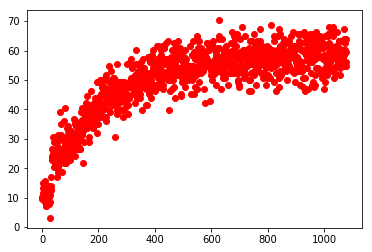

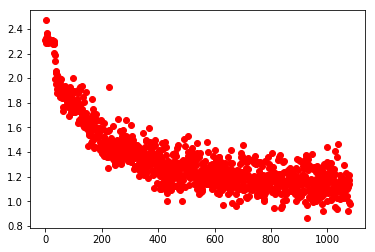

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

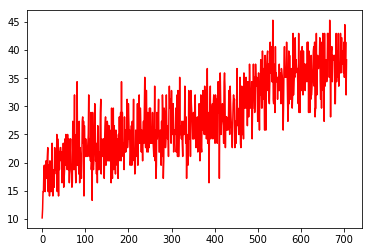

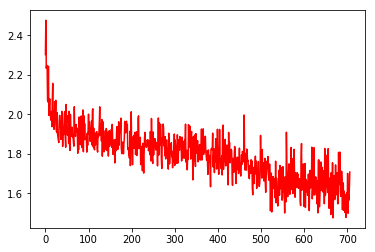

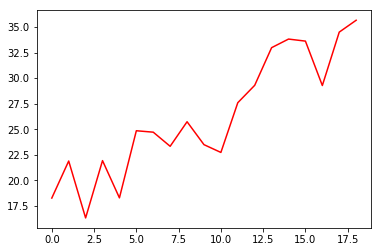

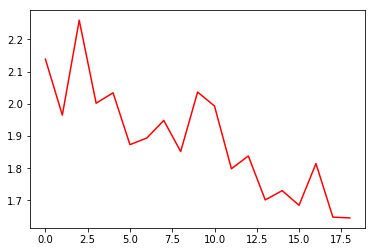

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()